In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read the CSV file
# Note: Replace 'your_file.csv' with your actual CSV file path
df = pd.read_csv('General_Education_School.csv')

# Display the first few rows of the dataset
df.head()




,DBN,School Name,School Type,Parent Response Rate,Teacher Response Rate,Student Response Rate,Total Safety and Respect Score,Total Communication Score,Total Engagement Score,Total Academic Expectations Score
0,dbn,locationname,NaN,rr_p,rr_t,rr_s,saf_tot_12,com_tot_12,eng_tot_12,aca_tot_12
1,01M015,P.S. 015 Roberto Clemente,Elementary School,61%,92%,NaN,8.4,8.2,8.3,8.2
2,01M019,P.S. 019 Asher Levy,Elementary School,92%,94%,NaN,8.4,8,8,8.2
3,01M020,P.S. 020 Anna Silver,Elementary School,88%,73%,NaN,8.5,7.8,8.2,8.2
4,01M034,P.S. 034 Franklin D. Roosevelt,Elementary/Middle School,39%,58%,96%,7.3,6.9,7.3,7.7


In [94]:
#duplicates_all = df[df.duplicated(keep=False)]
print( df.shape)

print(df.duplicated().sum())
df = df.drop_duplicates()


df.shape


(1671, 10)
3


(1668, 10)

In [95]:

# Remove the first row (it's not real data, it's a header misread)
df = df.iloc[1:].reset_index(drop=True)


In [96]:
print("Column Data Types:\n", df.dtypes)


Column Data Types:
 DBN                                  object
School Name                          object
School Type                          object
Parent Response Rate                 object
Teacher Response Rate                object
Student Response Rate                object
Total Safety and Respect Score       object
Total Communication Score            object
Total Engagement Score               object
Total Academic Expectations Score    object
dtype: object


In [97]:
nulls = df.isnull().sum()
nulls

DBN                                    0
School Name                            0
School Type                            0
Parent Response Rate                   0
Teacher Response Rate                  0
Student Response Rate                673
Total Safety and Respect Score         0
Total Communication Score              0
Total Engagement Score                 0
Total Academic Expectations Score      0
dtype: int64

In [98]:
# Convert percentage columns to numeric (remove % and convert to float)
percent_cols = ['Parent Response Rate', 'Teacher Response Rate', 'Student Response Rate']
for col in percent_cols:
    df[col] = df[col].str.replace('%', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='ignore')

score_cols = ['Total Safety and Respect Score', 'Total Communication Score', 'Total Engagement Score', 'Total Academic Expectations Score']
for col in score_cols:
    df[col] = pd.to_numeric(df[col], errors='ignore')

# Show cleaned info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   DBN                                1667 non-null   object 
 1   School Name                        1667 non-null   object 
 2   School Type                        1667 non-null   object 
 3   Parent Response Rate               1667 non-null   int64  
 4   Teacher Response Rate              1667 non-null   int64  
 5   Student Response Rate              994 non-null    float64
 6   Total Safety and Respect Score     1667 non-null   float64
 7   Total Communication Score          1667 non-null   float64
 8   Total Engagement Score             1667 non-null   float64
 9   Total Academic Expectations Score  1667 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 130.4+ KB
None


In [99]:

# Show unique school types where student response rate is null
student_rate_nulls = df[df['Student Response Rate'].isna()]['School Type']

null_student_rate_types = student_rate_nulls.unique()
print("\nSchool types with missing Student Response Rate:", null_student_rate_types)

# Count of each school type where Student Response Rate is null
null_rate_counts = student_rate_nulls.value_counts()
print("\nCount of each school type with missing Student Response Rate:\n", null_rate_counts)

# Total number of schools per school type
total_by_type = df['School Type'].value_counts()

# Example row for each school type with missing Student Response Rate
example_rows = df[df['Student Response Rate'].isna()].groupby('School Type').head(1)
print("\nExample rows where Student Response Rate is missing by school type:\n", example_rows[['School Name', 'School Type', 'Student Response Rate']])

null_percentage = (null_rate_counts / total_by_type) * 100

# Sort for readability
null_percentage = null_percentage.sort_values(ascending=False)

print("\nPercentage of missing Student Response Rate per school type:\n", null_percentage)



School types with missing Student Response Rate: ['Elementary School' 'Early Childhood School' 'Middle School']

Count of each school type with missing Student Response Rate:
 School Type
Elementary School         589
Early Childhood School     81
Middle School               3
Name: count, dtype: int64

Example rows where Student Response Rate is missing by school type:
                     School Name             School Type  Student Response Rate
0     P.S. 015 Roberto Clemente       Elementary School                    NaN
54   Yorkville Community School  Early Childhood School                    NaN
397         P.S. 002 Morrisania           Middle School                    NaN

Percentage of missing Student Response Rate per school type:
 School Type
Early Childhood School           100.000000
Elementary School                 95.461912
Middle School                      1.027397
Elementary/Middle School                NaN
Elementary/Middle/High School           NaN
High School   

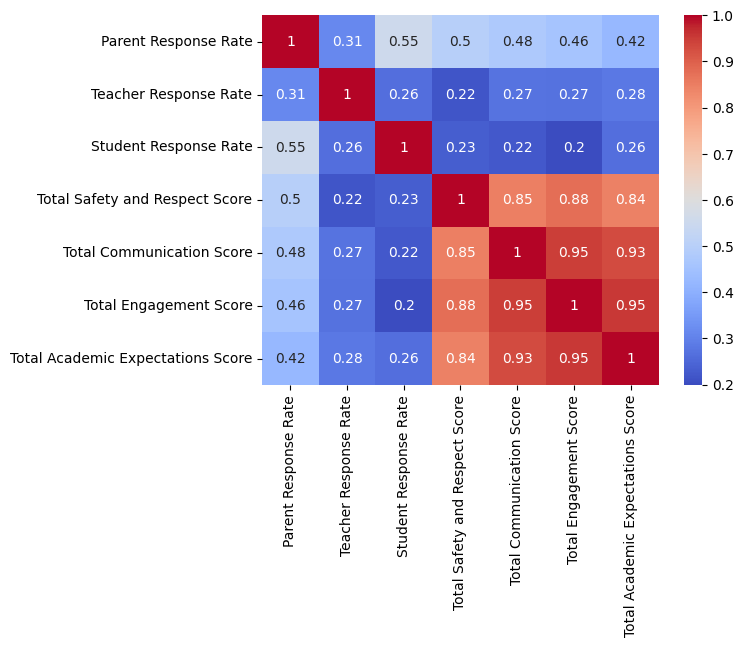

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

In [110]:
# ---------- 9. Category vs. Numerical Relationship ----------
# Analyze the relationship between School Type (categorical) and all numeric columns
numeric_cols = percent_cols + score_cols

# 9.1 Group means for each numeric column by School Type
group_means = df.groupby('School Type')[numeric_cols].mean()
print( """
Group Means by School Type for all numeric columns:
""", group_means)

# 9.2 ANOVA to test if mean differences are significant across School Types
from scipy.stats import f_oneway
anova_results = {}
for col in numeric_cols:
    groups = [group[col].dropna() for _, group in df.groupby('School Type')]
    # Only perform ANOVA if there are at least two groups with data
    if len([g for g in groups if len(g) > 0]) > 1:
        f_stat, p_val = f_oneway(*groups)
        anova_results[col] = {'F-statistic': f_stat, 'p-value': p_val}
    else:
        anova_results[col] = {'F-statistic': None, 'p-value': None}

anova_df = pd.DataFrame(anova_results).T
print("""
ANOVA Results (F-statistic and p-value) for each numeric column:
""", anova_df)





Group Means by School Type for all numeric columns:
                                Parent Response Rate  Teacher Response Rate  \
School Type                                                                  
Early Childhood School                    76.481481              88.444444   
Elementary School                         68.526742              82.418152   
Elementary/Middle School                  60.937500              82.518750   
Elementary/Middle/High School             54.714286              76.285714   
High School                               35.093750              84.252841   
Middle School                             58.681507              83.832192   
Middle/High School                        40.218391              80.045977   
Transfer High School                      35.653061              89.959184   
YABC                                      25.863636              80.545455   

                               Student Response Rate  \
School Type                    

c:\Users\mahmo\anaconda3\envs\tensorflow_env\lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


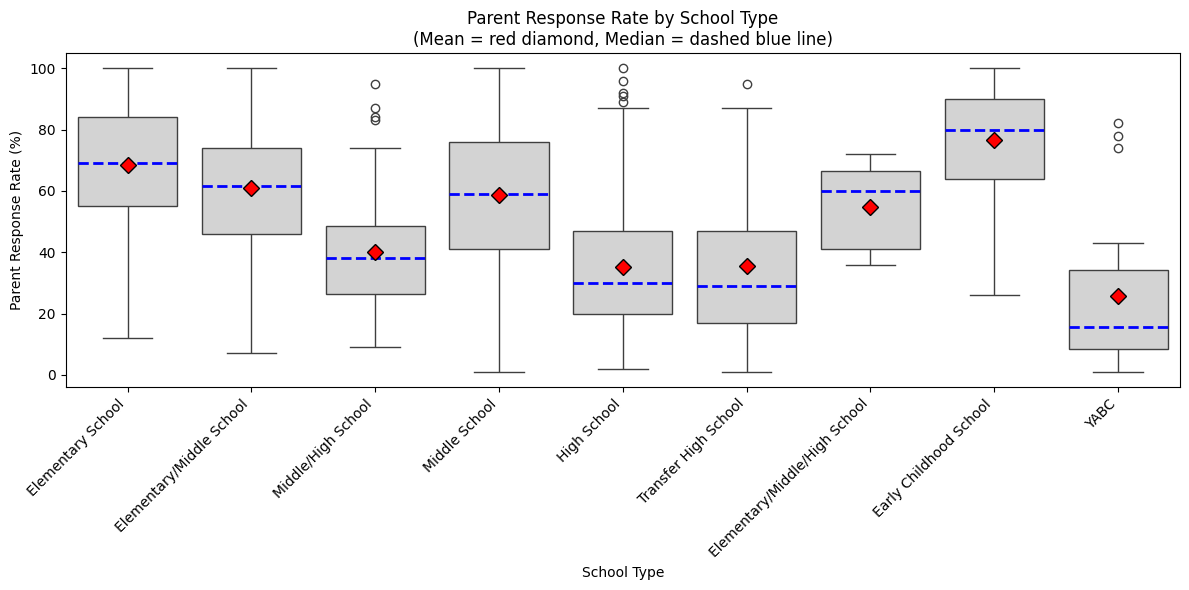

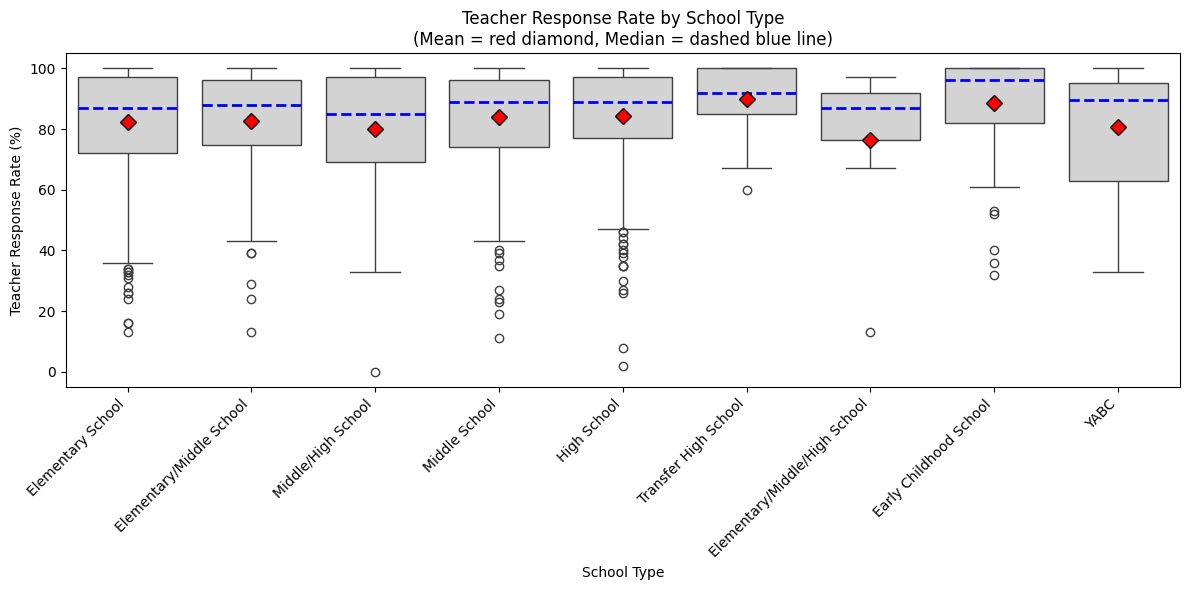

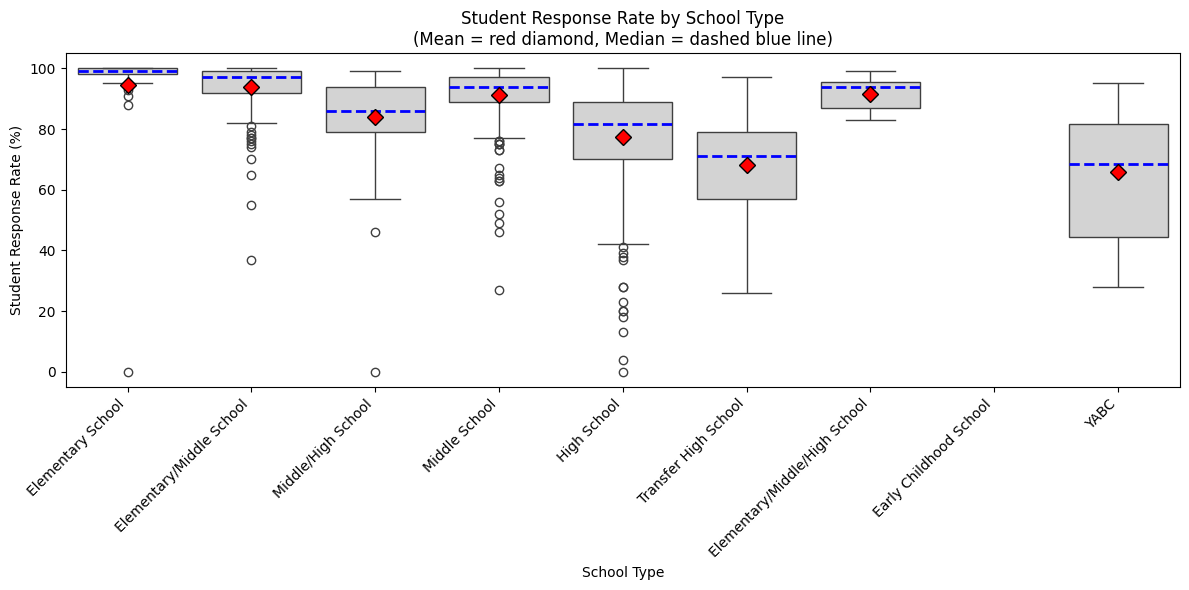

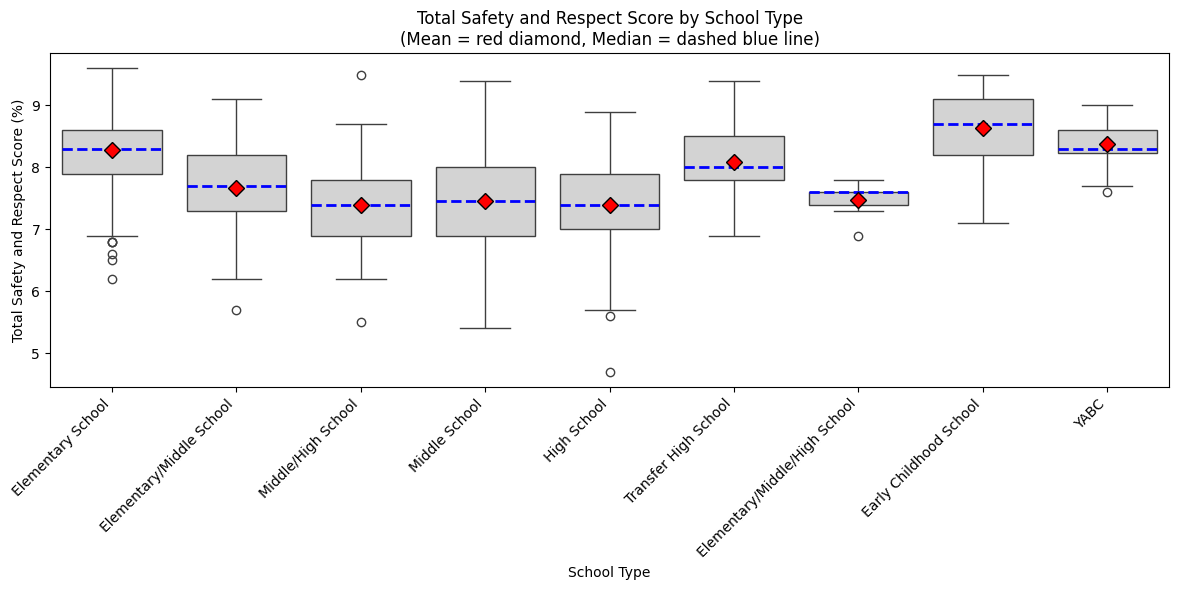

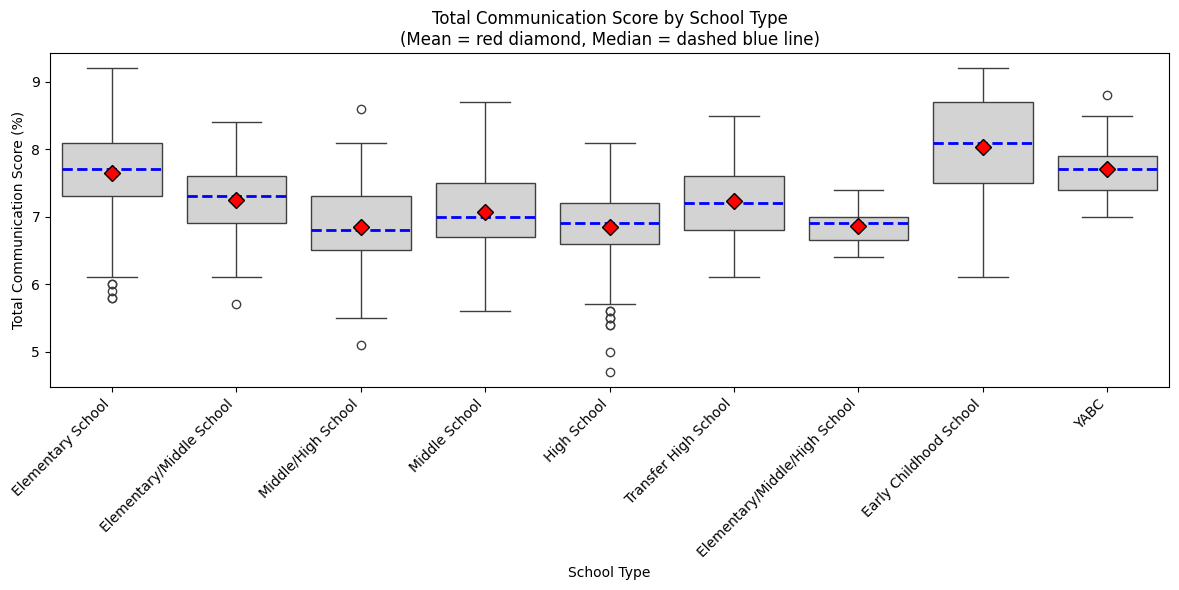

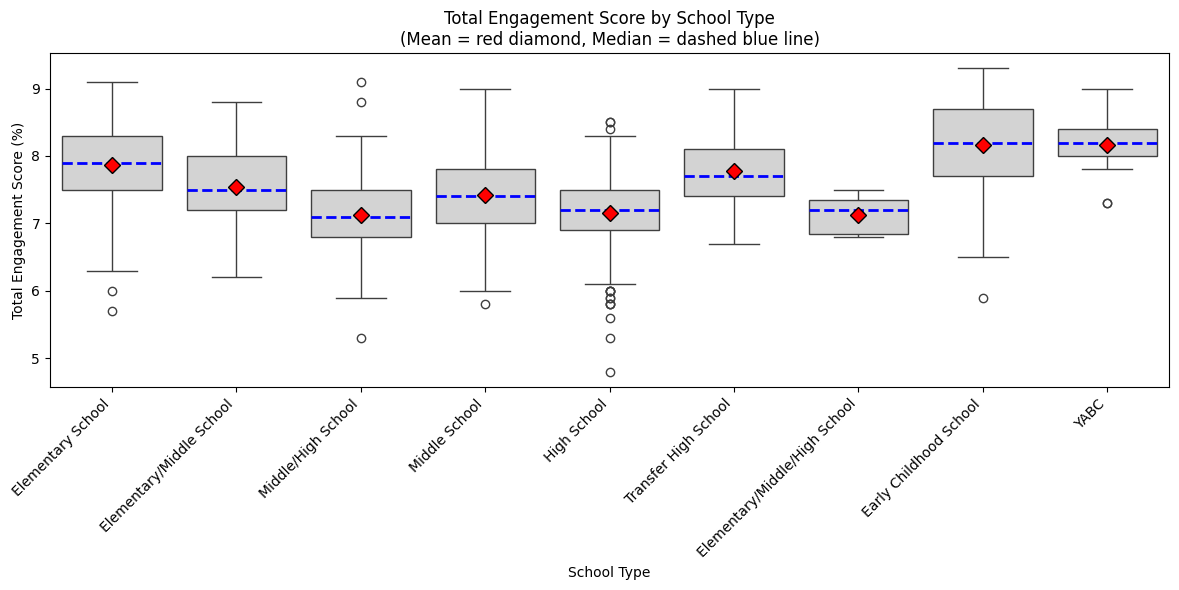

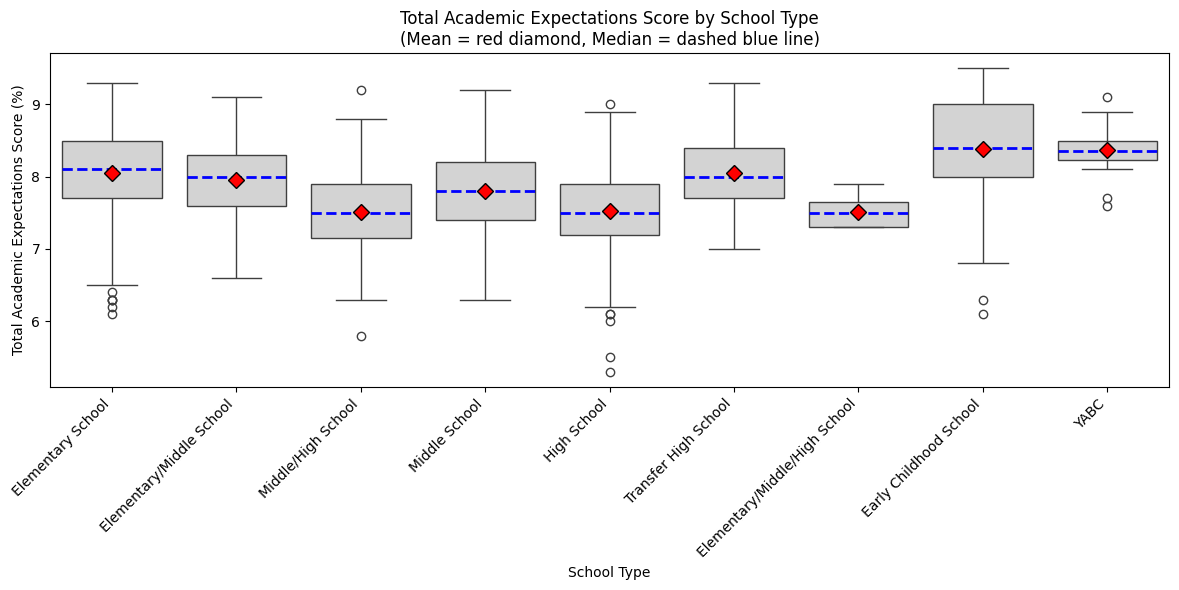

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of the other rate columns
other_rates = ['Parent Response Rate', 'Teacher Response Rate']

for col in numeric_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df,
        x='School Type',
        y=col,
        showmeans=True,
        meanprops={
            'marker': 'D',
            'markerfacecolor': 'red',
            'markeredgecolor': 'black',
            'markersize': 8
        },
        medianprops={
            'linestyle': '--',
            'linewidth': 2,
            'color': 'blue'
        },
        boxprops={'facecolor': 'lightgray'}
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f'{col} (%)')
    plt.title(f'{col} by School Type\n(Mean = red diamond, Median = dashed blue line)')
    plt.tight_layout()
    plt.show()


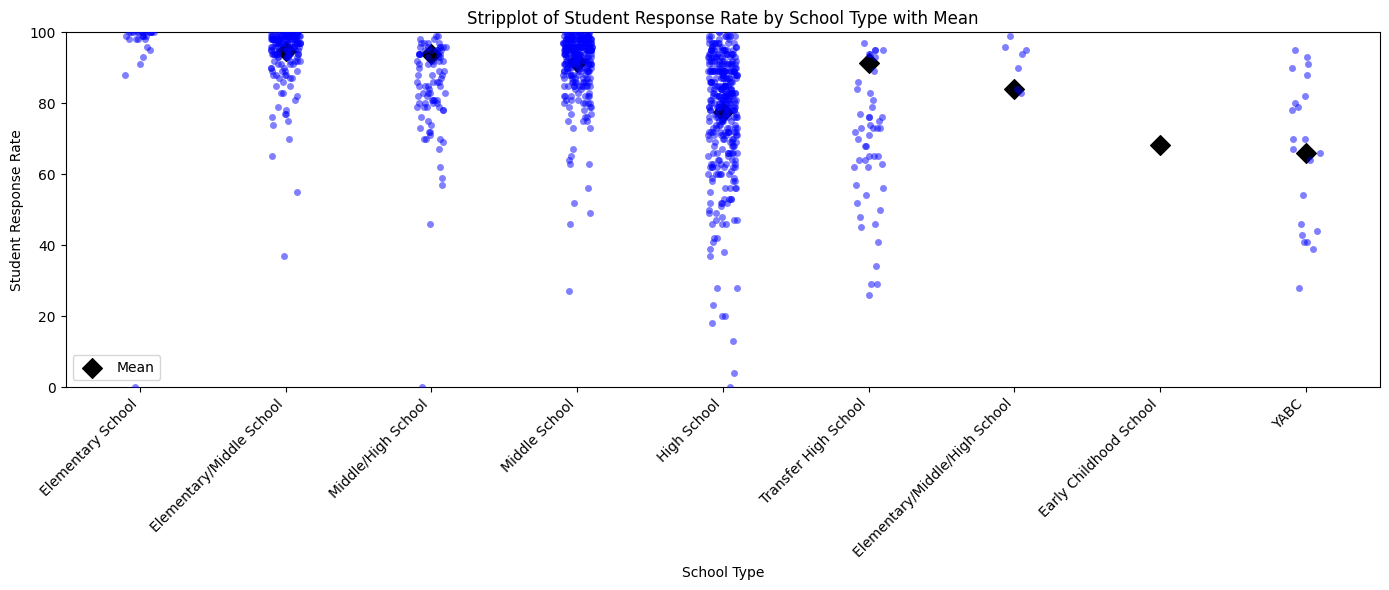

In [113]:

# 9.4 Stripplot of Student Response Rate by School Type with Mean Overlay
plt.figure(figsize=(14, 6))
sns.stripplot(
    data=df,
    x='School Type',
    y='Student Response Rate',
    jitter=True,
    alpha=0.5,
    color='blue'
)
# Calculate means
means = df.groupby('School Type')['Student Response Rate'].mean()
# Overlay mean markers
plt.scatter(
    x=range(len(means)),
    y=means.values,
    s=100,
    color='black',
    marker='D',
    label='Mean'
)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.title('Stripplot of Student Response Rate by School Type with Mean')
plt.legend()
plt.tight_layout()
plt.show()


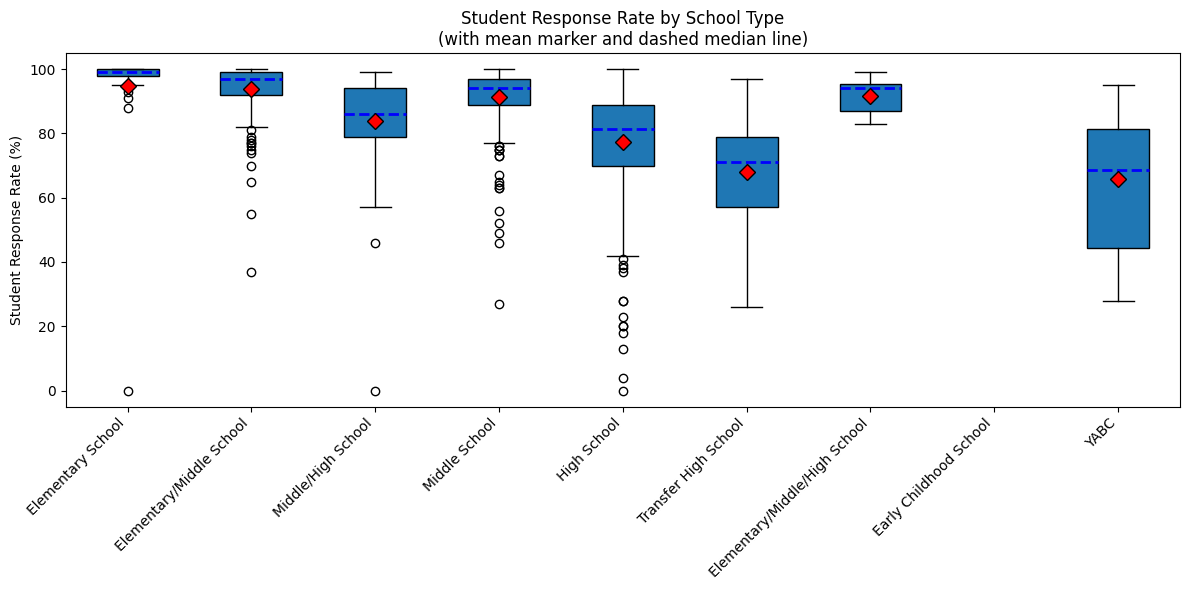

In [116]:
import matplotlib.pyplot as plt

# Prepare data in list‐of‐arrays form
school_types = df['School Type'].unique()
data = [df.loc[df['School Type'] == st, 'Student Response Rate'].dropna()
        for st in school_types]

plt.figure(figsize=(12, 6))

# Use matplotlib’s boxplot directly so we can control mean & median
plt.boxplot(
    data,
    labels=school_types,
    showmeans=True,
    meanprops={
        'marker': 'D',
        'markeredgecolor': 'black',
        'markerfacecolor': 'red',
        'markersize': 8
    },
    medianprops={
        'linestyle': '--',
        'linewidth': 2,
        'color': 'blue'
    },
    patch_artist=True
)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Student Response Rate (%)')
plt.title('Student Response Rate by School Type\n(with mean marker and dashed median line)')
plt.tight_layout()
plt.show()


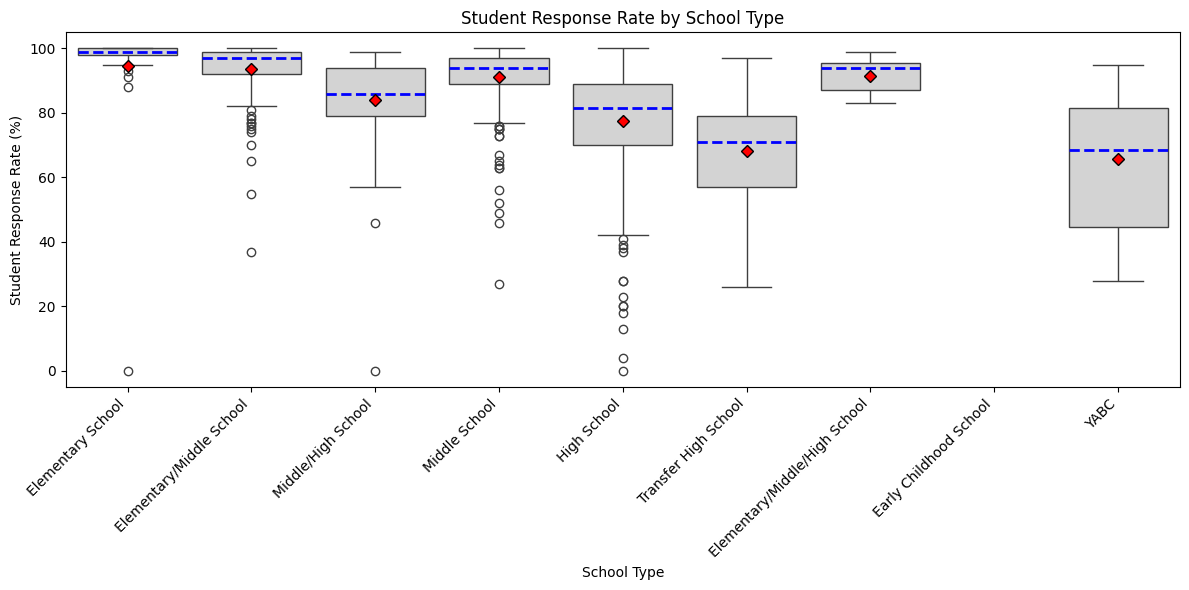

In [117]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='School Type',
    y='Student Response Rate',
    showmeans=True,
    meanprops={'marker':'D', 'markerfacecolor':'red', 'markeredgecolor':'black'},
    medianprops={'linestyle':'--', 'color':'blue', 'linewidth':2},
    boxprops={'facecolor':'lightgray'}
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Student Response Rate (%)')
plt.title('Student Response Rate by School Type')
plt.tight_layout()
plt.show()
